In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-11 20:11:29,671: Credentials are already in use. The existing account in the session will be replaced.


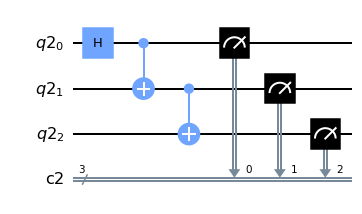

In [6]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

In [9]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'cx', 'measure', 'u3', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [ ]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=bit_flip_err)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(ghz_circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)